# test_lens_kinematic

Notebook 版的 `hmc_scripts/run_lens_kin_hmc.py`，包含 clean/noisy 两次 HMC、divergence 打印、trace plot 与 overlay corner。

In [1]:
import os
os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, init_to_value
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

USE_X64 = os.environ.get("SLCOSMO_USE_X64", "0").strip().lower() in {"1", "true", "yes", "y", "on"}
jax.config.update("jax_enable_x64", USE_X64)
if USE_X64:
    numpyro.enable_x64()
if any(d.platform == "gpu" for d in jax.devices()):
    numpyro.set_platform("gpu")
else:
    numpyro.set_platform("cpu")
print("Precision mode:", "FP64" if USE_X64 else "FP32")

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

TEST_MODE = False
RESULT_DIR = Path('/mnt/lustre/tianli/LensedUniverse_result')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = workdir / 'result'
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get('SLCOSMO_DATA_DIR', str(workdir / 'data')))

Precision mode: FP32


In [3]:
cosmo_true = {'Omegam': 0.32, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}
cosmo_prior = {
    'w0_up': 0.0, 'w0_low': -2.0,
    'wa_up': 2.0, 'wa_low': -2.0,
    'omegak_up': 1.0, 'omegak_low': -1.0,
    'h0_up': 80.0, 'h0_low': 60.0,
    'omegam_up': 0.5, 'omegam_low': 0.1,
}

LUT = np.load(DATA_DIR / 'velocity_disp_table.npy')
N1, N2, N3, N4 = LUT.shape
thetaE_grid = np.linspace(0.5, 3.0, N1)
gamma_grid = np.linspace(1.2, 2.8, N2)
Re_grid = np.linspace(0.15, 3.0, N3)
beta_grid = np.linspace(-0.5, 0.8, N4)
jampy_interp = tool.make_4d_interpolant(thetaE_grid, gamma_grid, Re_grid, beta_grid, LUT)

Euclid_GG_data = np.loadtxt(DATA_DIR / 'Euclid_len.txt')
zl_lens = Euclid_GG_data[:, 0]
zs_lens = Euclid_GG_data[:, 1]
Ein_lens = Euclid_GG_data[:, 2]
re_lens = Euclid_GG_data[:, 5]

mask_lens = (Ein_lens >= 0.6) & (re_lens >= 0.25) & (re_lens <= 2.8)
zl_lens = zl_lens[mask_lens]
zs_lens = zs_lens[mask_lens]
thetaE_lens = Ein_lens[mask_lens]
re_lens = re_lens[mask_lens]

_dl, ds_lens, dls_lens = tool.dldsdls(zl_lens, zs_lens, cosmo_true, n=20)
N_lens = len(zl_lens)

gamma_true = tool.truncated_normal(2.0, 0.2, 1.6, 2.4, N_lens, random_state=rng_np)
beta_true = tool.truncated_normal(0.0, 0.2, -0.4, 0.4, N_lens, random_state=rng_np)
vel_model = jampy_interp(thetaE_lens, gamma_true, re_lens, beta_true) * jnp.sqrt(ds_lens / dls_lens)

lambda_true = tool.truncated_normal(1.0, 0.05, 0.9, 1.1, N_lens, random_state=rng_np)
vel_true = vel_model * jnp.sqrt(lambda_true)

theta_E_err = 0.01 * thetaE_lens
vel_err = 0.1 * vel_true

gamma_obs_clean = gamma_true
theta_E_obs_clean = thetaE_lens
vel_obs_clean = vel_true

gamma_obs_noisy = gamma_true + tool.truncated_normal(0.0, 0.05, -0.2, 0.2, N_lens, random_state=rng_np)
theta_E_obs_noisy = thetaE_lens + np.random.normal(0.0, theta_E_err)
vel_obs_noisy = np.random.normal(vel_true, vel_err)

def build_data(gamma_obs, theta_E_obs, vel_obs):
    return {
        'zl': zl_lens,
        'zs': zs_lens,
        'theta_E': theta_E_obs,
        'theta_E_err': theta_E_err,
        're': re_lens,
        'gamma_obs': gamma_obs,
        'vel_obs': vel_obs,
        'vel_err': vel_err,
    }

lens_data_clean = build_data(gamma_obs_clean, theta_E_obs_clean, vel_obs_clean)
lens_data_noisy = build_data(gamma_obs_noisy, theta_E_obs_noisy, vel_obs_noisy)
print('N_lens =', N_lens)

N_lens = 5562


In [4]:
vel_model.max()

Array(385.77597, dtype=float32)

## Noisy Data Distributions (Before HMC)
Print noisy-data statistics and draw multiple histogram groups before running HMC.


Noisy-data summary (min, p05, median, p95, max, mean, std)
 gamma_obs_noisy: min=1.49744, p05=1.70059, med=1.99519, p95=2.30774, max=2.51111, mean=1.99791, std=0.182355
theta_E_obs_noisy: min=0.584821, p05=0.625756, med=0.899368, p95=1.68233, max=2.91722, mean=0.990759, std=0.343554
   vel_obs_noisy: min=78.3125, p05=144.205, med=199.171, p95=284.278, max=416.886, mean=204.612, std=43.3151
         vel_err: min=12.5757, p05=15.2953, med=20.0354, p95=27.5961, max=38.489, mean=20.4886, std=3.80307
     gamma_noise: min=-0.194311, p05=-0.082927, med=0.00140079, p95=0.0820631, max=0.19473, mean=0.00099697, std=0.0509181
   theta_E_noise: min=-0.0499414, p05=-0.0164658, med=4.07993e-05, p95=0.0166349, max=0.0721106, mean=6.3568e-05, std=0.0104462
       vel_noise: min=-99.3843, p05=-34.3904, med=-0.370564, p95=33.4051, max=89.1906, mean=-0.274562, std=20.9791
  vel_noise_norm: min=-3.9224, p05=-1.67437, med=-0.0172153, p95=1.61649, max=3.52906, mean=-0.0136284, std=1.00486


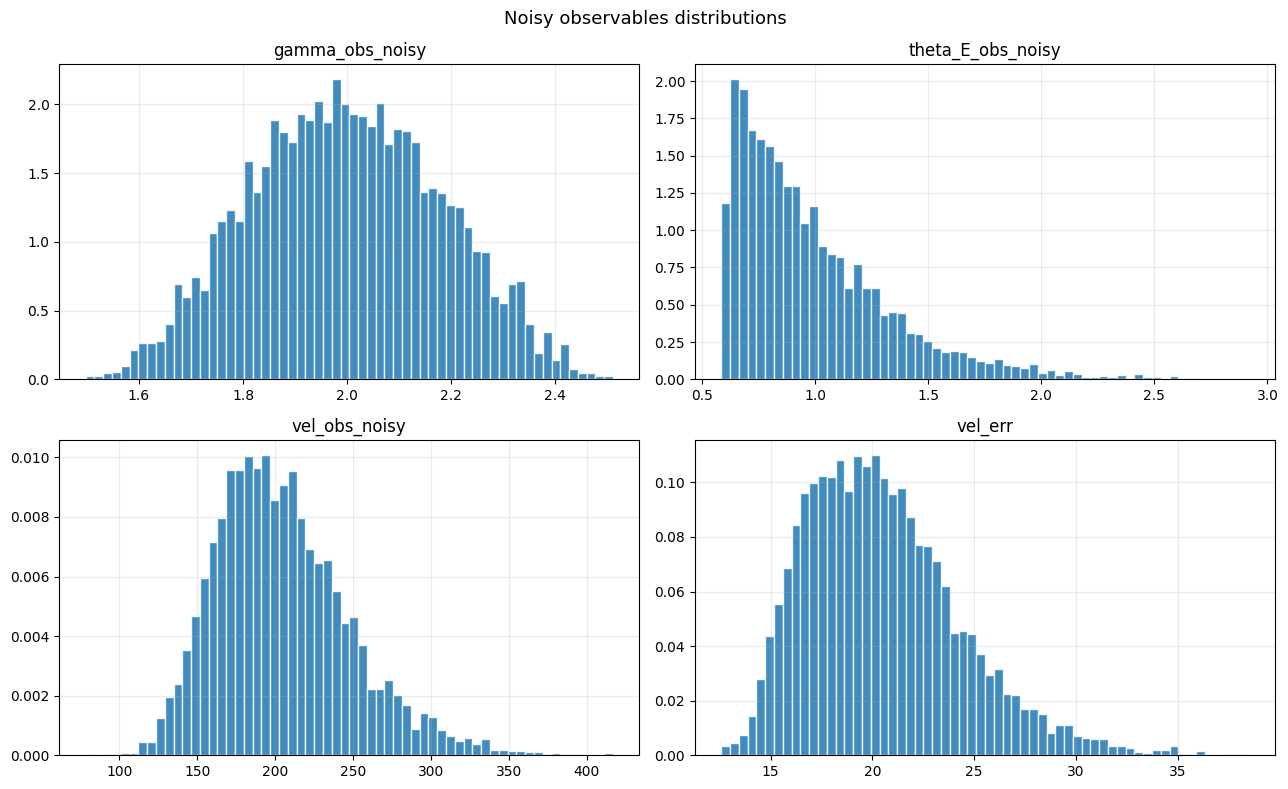

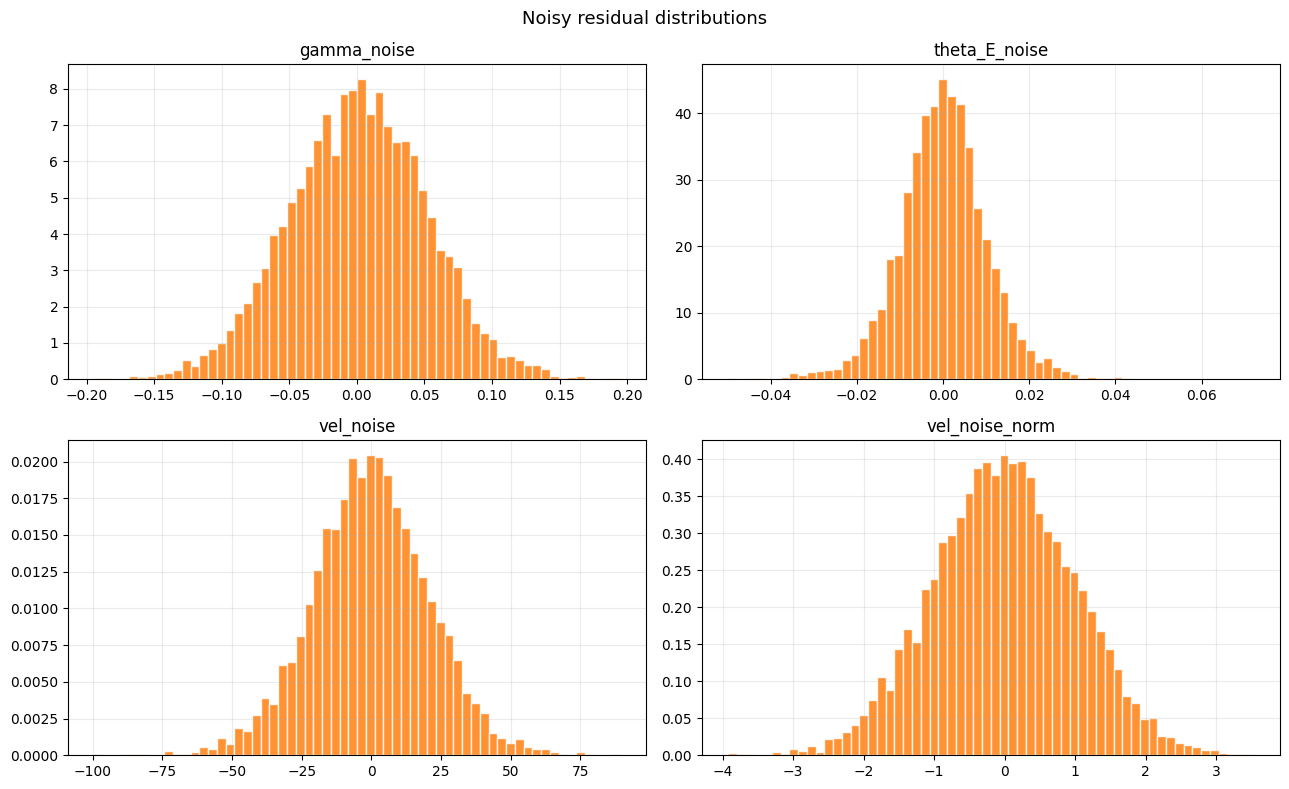

In [5]:
# Noisy data summary and histograms (run this before HMC)
vel_true_np = np.asarray(vel_true)

noisy_obs = {
    'gamma_obs_noisy': np.asarray(gamma_obs_noisy),
    'theta_E_obs_noisy': np.asarray(theta_E_obs_noisy),
    'vel_obs_noisy': np.asarray(vel_obs_noisy),
    'vel_err': np.asarray(vel_err),
}

noisy_resid = {
    'gamma_noise': np.asarray(gamma_obs_noisy - gamma_true),
    'theta_E_noise': np.asarray(theta_E_obs_noisy - thetaE_lens),
    'vel_noise': np.asarray(vel_obs_noisy - vel_true_np),
    'vel_noise_norm': np.asarray((vel_obs_noisy - vel_true_np) / np.where(vel_err > 0, vel_err, 1.0)),
}

print('Noisy-data summary (min, p05, median, p95, max, mean, std)')
for name, arr in {**noisy_obs, **noisy_resid}.items():
    q = np.quantile(arr, [0.05, 0.50, 0.95])
    print(
        f"{name:>16}: min={arr.min():.6g}, p05={q[0]:.6g}, med={q[1]:.6g}, "
        f"p95={q[2]:.6g}, max={arr.max():.6g}, mean={arr.mean():.6g}, std={arr.std(ddof=1):.6g}"
    )

fig1, axes1 = plt.subplots(2, 2, figsize=(13, 8))
for ax, (name, arr) in zip(axes1.flat, noisy_obs.items()):
    ax.hist(arr, bins=60, density=True, alpha=0.85, color='tab:blue', edgecolor='white')
    ax.set_title(name)
    ax.grid(alpha=0.25)
fig1.suptitle('Noisy observables distributions', fontsize=13)
fig1.tight_layout()

fig2, axes2 = plt.subplots(2, 2, figsize=(13, 8))
for ax, (name, arr) in zip(axes2.flat, noisy_resid.items()):
    ax.hist(arr, bins=60, density=True, alpha=0.85, color='tab:orange', edgecolor='white')
    ax.set_title(name)
    ax.grid(alpha=0.25)
fig2.suptitle('Noisy residual distributions', fontsize=13)
fig2.tight_layout()


In [6]:
def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        'Omegam': numpyro.sample('Omegam', dist.Uniform(cosmo_prior['omegam_low'], cosmo_prior['omegam_up'])),
        'Omegak': 0.0,
        'w0': -1.0,
        'wa': 0.0,
        'h0': 70.0,
    }
    if kind in ['wcdm', 'owcdm', 'waw0cdm', 'owaw0cdm']:
        cosmo['w0'] = numpyro.sample('w0', dist.Uniform(cosmo_prior['w0_low'], cosmo_prior['w0_up']))
    if kind in ['waw0cdm', 'owaw0cdm']:
        cosmo['wa'] = numpyro.sample('wa', dist.Uniform(cosmo_prior['wa_low'], cosmo_prior['wa_up']))
    if kind in ['owcdm', 'owaw0cdm']:
        cosmo['Omegak'] = numpyro.sample('Omegak', dist.Uniform(cosmo_prior['omegak_low'], cosmo_prior['omegak_up']))
    if sample_h0:
        cosmo['h0'] = numpyro.sample('h0', dist.Uniform(cosmo_prior['h0_low'], cosmo_prior['h0_up']))
    return cosmo


def lens_model(lens_data):
    cosmo = cosmology_model('waw0cdm', cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample('lambda_mean', dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample('lambda_sigma', dist.Uniform(0.0, 0.2))

    gamma_mean = numpyro.sample('gamma_mean', dist.Uniform(1.8, 2.2))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.Uniform(0.0, 0.3))

    beta_mean = numpyro.sample('beta_mean', dist.Uniform(-0.2, 0.2))
    beta_sigma = numpyro.sample('beta_sigma', dist.Uniform(0.0, 0.3))

    _dl, ds_lens, dls_lens = tool.dldsdls(lens_data['zl'], lens_data['zs'], cosmo, n=20)
    N = len(lens_data['zl'])
    with numpyro.plate('lens', N):
        gamma_i = numpyro.sample('gamma_i', dist.TruncatedNormal(gamma_mean, gamma_sigma, low=1.2, high=2.8))
        beta_i = numpyro.sample('beta_i', dist.TruncatedNormal(beta_mean, beta_sigma, low=-0.5, high=0.5))
        lambda_lens = numpyro.sample('lambda_lens', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.5, high=1.5))
        theta_E_i = numpyro.sample('theta_E_i', dist.Normal(lens_data['theta_E'], lens_data['theta_E_err']))
        v_interp = jampy_interp(theta_E_i, gamma_i, lens_data['re'], beta_i)
        vel_pred = v_interp * jnp.sqrt(ds_lens / dls_lens) * jnp.sqrt(lambda_lens)

        numpyro.sample('gamma_obs_lens', dist.Normal(gamma_i, 0.05), obs=lens_data['gamma_obs'])
        numpyro.sample('vel_lens_like', dist.Normal(vel_pred, lens_data['vel_err']), obs=lens_data['vel_obs'])

In [7]:
def build_init_values(lens_data):
    gamma_i = np.asarray(lens_data['gamma_obs'], dtype=np.float64)
    gamma_i = np.clip(gamma_i, 1.201, 2.799)
    beta_i = np.zeros_like(gamma_i, dtype=np.float64)
    lambda_lens = np.ones_like(gamma_i, dtype=np.float64)
    lambda_lens = np.clip(lambda_lens, 0.501, 1.499)
    theta_E_i = np.asarray(lens_data['theta_E'], dtype=np.float64)
    theta_E_i = np.maximum(theta_E_i, 1e-3)
    return {
        'Omegam': jnp.asarray(cosmo_true['Omegam']),
        'w0': jnp.asarray(cosmo_true['w0']),
        'wa': jnp.asarray(cosmo_true['wa']),
        'h0': jnp.asarray(cosmo_true['h0']),
        'lambda_mean': jnp.asarray(1.0),
        'lambda_sigma': jnp.asarray(0.08),
        'gamma_mean': jnp.asarray(2.0),
        'gamma_sigma': jnp.asarray(0.2),
        'beta_mean': jnp.asarray(0.0),
        'beta_sigma': jnp.asarray(0.2),
        'gamma_i': jnp.asarray(gamma_i),
        'beta_i': jnp.asarray(beta_i),
        'lambda_lens': jnp.asarray(lambda_lens),
        'theta_E_i': jnp.asarray(theta_E_i),
    }


def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 1500, 4, 'vectorized'

    nuts = NUTS(
        lens_model,
        target_accept_prob=0.99,
        init_strategy=init_to_value(values=build_init_values(data)),
    )
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, lens_data=data)

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'lens_kin_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
    trace_fig = np.asarray(trace_axes).ravel()[0].figure
    trace_fig.savefig(FIG_DIR / f'lens_kin_trace_{tag}.png', dpi=200, bbox_inches='tight')
    plt.close(trace_fig)
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(lens_data_clean, key_clean, 'clean')
idata_noisy = run_mcmc(lens_data_noisy, key_noisy, 'noisy')

sample: 100%|██████████| 2000/2000 [05:41<00:00,  5.85it/s]


[clean] divergences: 1170


sample: 100%|██████████| 2000/2000 [04:07<00:00,  8.09it/s]


[noisy] divergences: 54


In [8]:
corner_vars = select_corner_vars(
    idata_clean,
    idata_noisy,
    ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma'],
)
make_overlay_corner(idata_clean, idata_noisy, corner_vars, FIG_DIR / 'lens_kin_corner_overlay.pdf')
print('Saved:')
print(RESULT_DIR / 'lens_kin_clean.nc')
print(RESULT_DIR / 'lens_kin_noisy.nc')
print(FIG_DIR / 'lens_kin_trace_clean.pdf')
print(FIG_DIR / 'lens_kin_trace_noisy.pdf')
print(FIG_DIR / 'lens_kin_corner_overlay.pdf')

Saved:
/mnt/lustre/tianli/LensedUniverse_result/lens_kin_clean.nc
/mnt/lustre/tianli/LensedUniverse_result/lens_kin_noisy.nc
/users/tianli/LensedUniverse/result/lens_kin_trace_clean.pdf
/users/tianli/LensedUniverse/result/lens_kin_trace_noisy.pdf
/users/tianli/LensedUniverse/result/lens_kin_corner_overlay.pdf
